In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_predict

%matplotlib inline

/home/pataki/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [8]:
base = '/mnt/net/onco2/data0/users/pataki/AMR_pred/final_processed/'

data = pd.read_csv(f'{base}merged_top50.csv').fillna('NA')
data = data[data.measurement_units == 'mg/L']
data.pop('measurement_units');
data.pop('sample_alias');

trainDF = data[data.country != 'NA']
print(trainDF.shape)
trainDF.head()

(438, 52)


,country,measurement,CP009072.1_167295,CP009072.1_167306,CP009072.1_1589734,has_qnrS,qnrS1_1_AB187515,blaCTX-M-55_1_DQ810789,blaVIM-48_1_KY362199,CP009072.1_3517597,...,CP009072.1_4225633,blaTEM-45_1_X95401,CP009072.1_3042255,CP009072.1_3246445,CP009072.1_4003840,CP009072.1_1205334,lnu(F)_1_EU118119,CP009072.1_3516092,CP009072.1_3486318,CP009072.1_1516325
0,Denmark,0.015,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Denmark,0.015,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,Denmark,0.015,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Denmark,0.015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Denmark,0.015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
score = []
for N in range(1,51):
    rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
               max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=5,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
               oob_score=False, random_state=42, verbose=0, warm_start=False)
    preds = []
    truth = []
    for i in pd.unique(trainDF.country.tolist()):
        # select N first featue (+2 is the two meta cols)
        train_X = trainDF[trainDF.country != i][trainDF.columns.values[:N+2]] 
        train_y = train_X.pop('measurement')
        train_X.pop('country')

        test_X = trainDF[trainDF.country == i][trainDF.columns.values[:N+2]] 
        test_y = test_X.pop('measurement')
        test_X.pop('country')

        rf.fit(train_X, np.log2(train_y))

        preds = preds + list(2**np.round(rf.predict(test_X)))
        truth = truth + list(test_y)
    score.append(r2_score(y_pred=np.log2(preds), y_true=np.log2(truth)))

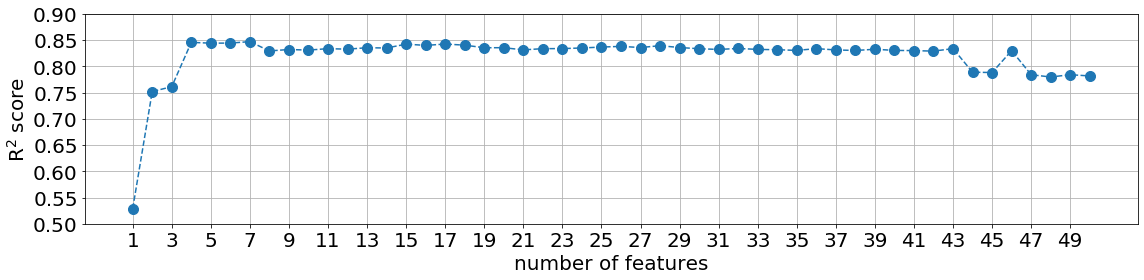

In [56]:
plt.figure(figsize=(16, 4))
plt.plot(range(1, 51), score, marker='o', linestyle='--', markersize=10)
plt.ylim(0.5, 0.90)
plt.ylabel(r'R$^2$ score', fontsize=20)
plt.xlabel('number of features', fontsize=20)
plt.xticks(range(1,51,2), [str(i) for i in range(1, 51,2)], fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig('../figs/feature_num.pdf')

In [36]:
trainDF.pop('country');
y = trainDF.pop('measurement')

In [44]:
rf.fit(trainDF[trainDF.columns.values[:4]], np.log2(y))

lr = LinearRegression()
lr.fit(trainDF[trainDF.columns.values[:4]], np.log2(y))

with open(f'{base}rf_4.pkl', 'wb') as f:
    pickle.dump(rf, f)
    
with open(f'{base}lr_4.pkl', 'wb') as f:
    pickle.dump(lr, f)

In [45]:
rf.fit(trainDF[trainDF.columns.values[:15]], np.log2(y))

lr = LinearRegression()
lr.fit(trainDF[trainDF.columns.values[:15]], np.log2(y))

with open(f'{base}rf_15.pkl', 'wb') as f:
    pickle.dump(rf, f)
    
with open(f'{base}lr_15.pkl', 'wb') as f:
    pickle.dump(lr, f)